# Bases de Datos y Métricas de Evaluación

En este tutorial desarrollaremos ejercicios prácticos que nos permitirán comprender cómo podemos evaluar el desempeño de algoritmos de clasificación, detección y segmentación mediante algunas de las métricas estudiadas en clase, tales como la precisión, la cobertura, la F-medida, el índice de Jaccard y otras herramientas como las matrices de confusión y las curvas de precisión y cobertura.

## Evaluación de Modelos de Clasificación

La tarea de clasificación corresponde a asignarle una instancia semántica a cada elemento de un conjunto a clasificar. En otras palabras, un algoritmo de clasificación le asigna una etiqueta a cada elemento de la base de datos estudiada. Si bien en este curso trabajaremos con bases de datos de imágenes, en un contexto general también podemos clasificar otros tipos de datos como textos, audios o datos numéricos. Para este primer ejercicio asumiremos que usted diseñó un modelo de clasificación que recibe como entrada un archivo de audio y retorna el género asociado a dicha canción, tal como se ilustra en la siguiente figura:

![modelo_musica.png](modelo_musica.png)

**En esta etapa no debemos preocuparnos por cómo funciona este modelo, pues solo queremos evaluar qué tan bien hace su trabajo.**

Para construir este modelo usted empleó una base de datos que contiene 700 canciones y anotaciones de sus respectivos géneros. Usted decidió emplear 60% de los datos como conjunto de entrenamiento. Después de construir varios modelos, empleó otro 20% de la base de datos como conjunto de validación para comparar el desempeño de cada uno y definir cuál es el mejor. Ahora usted se dispone a emplear el 20% restante de la base de datos como conjunto de prueba para evaluar la capacidad de generalización de su mejor modelo.

Su conjunto de prueba, compuesto por 140 canciones, tiene la siguiente distribución de canciones por género, donde cada género tiene una etiqueta asociada:

| Género | Etiqueta | Cantidad de Canciones |
|--------|----------|-----------------------|
|  Rock  |     1    |           30          |
|  Jazz  |     2    |           20          |
|   Pop  |     3    |           50          |
|   Rap  |     4    |           30          |
|  Salsa |     5    |           10          |

En el archivo `music_data.csv` se encuentran las etiquetas correspondientes a los géneros predichos por su algoritmo para cada canción (columna titulada *prediction*) y las etiquetas correspondientes al género correcto (columna titulada *annotation*). Para 6 canciones cualquiera tenemos el siguiente ejemplo:

| prediction | annotation |
|------------|------------|
|     1      |      1     |
|     1      |      3     |
|     3      |      2     |
|     3      |      4     |
|     1      |      5     |
|     2      |      2     |

>**Nota**: Los archivos CSV (*Comma-Separated Values*) son archivos delimitados de texto que separan sus valores mediante comas. Suelen ser empleados para almacenar información tabular. Explore el archivo `music_data.csv` para entender su estructura.


Utilizaremos la librería Pandas para importar este archivo a Python y guardar las predicciones y anotaciones como arreglos de Numpy, lo que nos permitirá calcular las métricas de evaluación de forma sencilla:

In [1]:
# librerías necesarias

import pandas as pd # pandas para manejar datos 
import numpy as np # numpy para operaciones numéricas
# Tratamos de importar la libreria.
try:
    from sklearn import metrics # sklearn para métricas de evaluación
except:
    # Si no está instalada, la instalamos
    !pip install -U scikit-learn
    from sklearn import metrics

import matplotlib.pyplot as plt # matplotlib para visualización de datos
import cv2 # cv2 para procesamiento de imágenes

ModuleNotFoundError: No module named 'matplotlib'

## Ejercicio 1:
Realice el contenido de la siguiente función, la cual le entra como parametro la ruta del archivo 'csv' que contiene las anotaciones y predicciones y retorna dos arreglos con predicciones y anotaciones respectivamente.
### **Notas** 
> - Para abrir el archivo puede usar la función *pd.read_csv('file_name.csv')* Esta función retorna un diccionario. Nuestro archivo tiene 2 llaves, una por cada columna.
> - Para obtener todos los datos de una columna solo debe indexar el diccionario con su respectiva llave.

In [17]:
def open_csv_data(file_name):
    '''
    file_name: nombre del archivo csv para abrir
    '''
    dic = pd.read_csv(file_name)
    predicciones = dic['prediction'] 
    anotaciones = dic['annotation']
    return predicciones, anotaciones

In [18]:
pred, annot = open_csv_data('music_data.csv')
print(f"Las predicciones de las primeras 5 canciones son: {pred[0],pred[1],pred[2],pred[3],pred[4]}")
print(f"Las anotaciones de las primeras 5 canciones son: {annot[0],annot[1],annot[2],annot[3],annot[4]}")
assert(len(pred)==140),f'La cantidad de datos de la prediccion debe ser 140 y es {len(pred)}'
assert(len(annot)==140),f'La cantidad de datos de la prediccion debe ser 140 y es {len(annot)}'
assert np.sum(pred==annot)!=140, 'Las anotaciones y las predicciones no deberian ser iguales'

Las predicciones de las primeras 5 canciones son: (np.float64(1.0), np.float64(1.0), np.float64(3.0), np.float64(3.0), np.float64(3.0))
Las anotaciones de las primeras 5 canciones son: (np.float64(1.0), np.float64(3.0), np.float64(2.0), np.float64(4.0), np.float64(3.0))


Los arreglos de numpy se pueden manipular de diversas formas. Los recorridos son un metodo poco eficiente cuando tratamos con una cantidad grande de datos. Los elementos de los arreglos pueden compararse uno a uno utilizando operadores lógicos como >, < o == evitando usar un for. Estas operaciones cambiarán los elementos de los arreglos por True o False segun la comparación dada.
Por ejemplo, si tenemos un arreglo **a** y queremos comparar cuales de sus valores son iguales a un entero **b** se puede utilizar el siguiente código:

In [19]:
# El arreglo a es un arreglo aleatorio de número del 0 al 4
a = np.array([3,1,2,1,3,0,0,3,1,2,3,3,2,3,0,3,2,2,1,1])
# El int b es el número contra el que queremos comparar cada una de los valores del arreglo
b = 1
# Si comparamos con == podemo observar donde cada uno de los valores del arreglo es igual a b
a==b

array([False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True])

Use esta metodología para obtener el porcentaje de datos bien clasificados, es decir, los verdaderos positivos para cada clase. Para obtener ese porcentaje hay que tener en cuenta que la comparación con operadores lógicos también se puede hacer entre arreglos. En ese caso la comparación se hace en cada posición de los dos arreglos que se quieren comparar y da como resultado un arreglo con valores de True o False. Además, si usamos np.sum() podremos saber cuantos True hay en un arreglo (python considera un True como un 1). Finalmente, podemos utilizar la siguiente ecuación para definir el porcentaje de verdaderos positivos:


$TP:=\frac{sum(comparison\_array)}{length(comparison\_array)}$


In [29]:
comparison_array = pred == annot # Arreglo en el que se guardaran la comparación entre los arreglos pred y annot
TP = sum(comparison_array)/len(comparison_array)# Porcentaje de verdaderos positivos para todas las clases. Dejarlo en términos decimales

print(f'El porcentage de verdaderos positivos es: {TP * 100}%')

El porcentage de verdaderos positivos es: 59.285714285714285%


In [30]:
assert np.isclose(np.sum(comparison_array),83,0.1),f'La cantidad de anotaciones de la clase 3 deberia ser 50 y es {np.sum(anotacion_3)}'
assert np.isclose(TP,0.593,0.1), 'El porcentaje de verdaderos positivos no esta bien calculada'

Saber la cantidad de verdaderos positivos solo nos ayuda a saber cuales datos tuvieron una predicción correcta, pero no podemos determinar la verdadera capacidad predictiva del algoritmo.

Nos centrémonos en analizar una clase de interés, por ejemplo, Jazz. Encontremos su Precisión, Cobertura y F-Medida asociada. Recordemos que, en términos de los errores y aciertos de una clase, podemos expresar estas métricas de la siguiente forma:

\begin{equation}
Precision = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
Cobertura = \frac{TP}{TP + FN}
\end{equation}
    
\begin{equation}
F_{medida} = \frac{2 (P \times C)}{P + C}
\end{equation}

Donde $TP$, $FP$, $FN$, $P$ y $C$ son *True Positives, False Positives, False Negatives,* Precisión y Cobertura respectivamente. 


## **Ejercicio 2:** 
Realice el contenido de la siguiente función, la cual le entra como parametro las anotaciones, predicciones y clase de la cual se quiere calcular las métricas. Esta función debe retornar la matriz de confusión: [[TP,FP],[FN,TN]].

**Nota:** Para simplificar no tengamos en cuenta los verdaderos negativos, es decir, asuma que son 0.

![matriz.png](matriz.png)

In [31]:
def Matriz(annots,preds,label):
    """
    annots: Etiquetas de anotación
    preds: Etiquetas de predicción
    label: Etiqueta utilizada para calcular la matriz de confusión
    """
    TP = np.sum((preds == label) & (annots == label))
    FP = np.sum((preds == label) & (annots != label))
    FN = np.sum((preds != label) & (annots == label))
    TN = 0    
    matriz = [[TP, FP], [FN, TN]]
    return matriz

La precisión, la cobertura y la F medida se pueden calcular a partir de la matriz de confusión. Si normalizamos por columna obtenemos la cobertura, si normalizamos por fila obtenemos la precisión, veamos si esto se cumple.

In [32]:
def prec_rec_fscore(annots,preds,label):
    # Crear arreglos booleanos que indiquen qué canciones tienen la etiqueta de Jazz en las predicciones y anotaciones
    jazz_pred = preds == label
    jazz_annot = annots == label

    # Los verdaderos positivos corresponden al producto punto entre estos dos arreglos
    TP = np.sum(jazz_pred * jazz_annot)

    # Los denominadores asociados a la precisión y cobertura pueden encontrarse mediante 
    # la suma de los elementos de estos arreglos

    TP_and_FP = np.sum(jazz_pred)
    TP_and_FN = np.sum(jazz_annot)

    # Cálculo de las métricas

    precision = TP / TP_and_FP
    cobertura = TP / TP_and_FN
    f_medida = 2 * precision * cobertura / (precision + cobertura)
    return precision,cobertura,f_medida

In [33]:
precision,cobertura,f_medida = prec_rec_fscore(annot,pred,2)
matriz=Matriz(annot,pred,2)
precision2=matriz[0][0]/np.sum(matriz[0])
cobertura2=matriz[0][0]/(matriz[0][0]+matriz[1][0])
f_medida2 = 2 * precision2 * cobertura2 / (precision2 + cobertura2)

print('Función:')
print("La precision para la clase de Jazz es: " + str(precision))
print("La cobertura para la clase de Jazz es: " + str(cobertura))
print("La F-medida para la clase de Jazz es: " + str(f_medida))

print('Matriz:')
print("La precision para la clase de Jazz es: " + str(precision2))
print("La cobertura para la clase de Jazz es: " + str(cobertura2))
print("La cobertura para la clase de Jazz es: " + str(f_medida2))
assert(precision==1.0)
assert(cobertura==0.25)
assert(f_medida==0.4)

assert precision==precision2, 'La precision deberia ser igual en ambos metodos'
assert cobertura==cobertura2, 'La cobertura deberia ser igual en ambos metodos'
assert f_medida==f_medida2, 'La f_medida deberia ser igual en ambos metodos'

Función:
La precision para la clase de Jazz es: 1.0
La cobertura para la clase de Jazz es: 0.25
La F-medida para la clase de Jazz es: 0.4
Matriz:
La precision para la clase de Jazz es: 1.0
La cobertura para la clase de Jazz es: 0.25
La cobertura para la clase de Jazz es: 0.4



¡Muy bien! Ya sabemos cómo calcular varias métricas asociadas a una clase. Sin embargo, nos gustaría evaluar el desempeño del algoritmo para cada clase. Podríamos simplemente replicar lo que acabamos de hacer 5 veces, pero esto definitivamente puede ser inoficioso cuando trabajemos con bases de datos de muchas clases. Para obtener una mejor idea de cómo se desempeña nuestro algoritmo en las distintas clases podemos calcular la matriz de confusión asociada, cuya estructura ya fue explicada en el curso. En el siguiente fragmento de código se propone una posible implementación:

La matriz de confusion es:


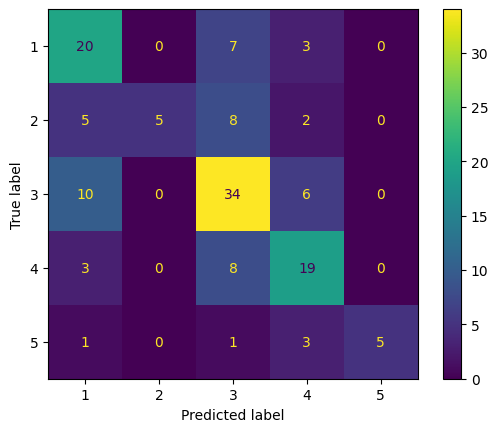

In [34]:
# Encuentra la cantidad de clases que hay en las anotaciones

tags = np.unique(annot)

# Inicializa la matriz de confusión con un arreglo de ceros de tamaño nxn
# donde n es la cantidad de clases en las anotaciones

n = len(tags)
conf_mat_1 = np.zeros((n, n))

# El valor de la casilla (i,j) corresponde a la cantidad de veces que 
# la clase correcta era la i y la clase predicha era la j.

for i in range(n):
    for j in range(n):
        conf_mat_1[i,j] = np.sum((annot == tags[i]) * (pred == tags[j]))

# Se puede utilizar la librería de sklearn, especificamente sklearn.metrics, para mejorar la estética
# de la siguiente manera.

# Crear la visualización de la matriz de confusión
conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_1, display_labels = [1,2,3,4,5])

print("La matriz de confusion es:")

# Graficar la matriz de confusión
conf_mat.plot()
plt.show()

Muchas veces nuestras implementaciones de algoritmos comunes (como obtener una matriz de confusión) son poco eficientes, o incluso idear una implementación requiere de un gran esfuerzo y puede no ser el foco central de nuestro trabajo. Afortunadamente existen librerías con implementaciones eficientes que nos pueden ahorrar este trabajo. A continuación, emplearemos la librería sklearn para obtener una matriz de confusión:

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat_2 = confusion_matrix(annot, pred)

print("La matriz de confusion es:")
# Crear la visualización de la matriz de confusión
conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_2, display_labels = [1,2,3,4,5])

# Graficar la matriz de confusión
conf_mat.plot()
plt.show()

## Evaluación de Modelos de Detección
La detección es, en general, un problema de clasificación binaria con clases desbalanceadas. Sin embargo, en el campo de la Visión por Computador usualmente la tarea de detección se relaciona con identificar y localizar las instancias de una clase en una imagen (Reflexione acerca de por qué esta es una tarea de clasificación desbalanceada). Por ejemplo, para este punto asuma que usted desarrolló un modelo cuyo objetivo es detectar los teléfonos celulares que se usan en una tribuna para grabar conciertos, como en la siguiente imagen:

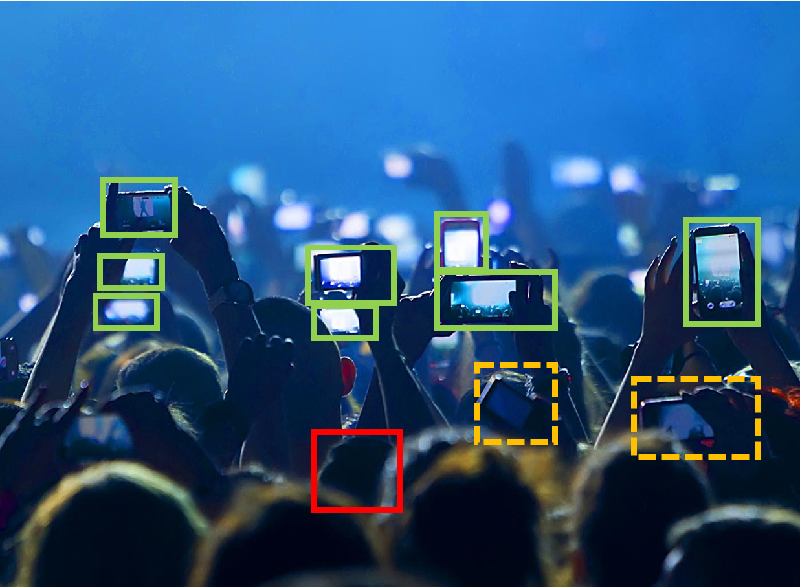

Los recuadros verdes representan los celulares que su modelo logró detectar ($TP$), los recuadros rojos son aquellas porciones de la imagen en las que su modelo estableció que había un celular pero en realidad no lo había ($FP$) y los recuadros amarillos son aquellos celulares que su modelo no detectó ($FN$).

Los modelos o algoritmos que se emplean en las tareas de detección suelen tener un *nivel de confianza* asociado. Esto significa que cada posible detección viene acompañada de un número que indica qué tan seguro está el modelo de que sea un positivo. Este número se suele interpretar como una probabilidad, y por lo tanto, está entre 0 y 1. En este orden de ideas, para estos modelos se puede variar un *umbral de confianza* a partir del cual los candidatos con un *nivel de confianza* mayor a este umbral son considerados como positivos. Si el umbral es bajo, muchos candidatos serán positivos y probablemente el modelo incurrirá en más falsos positivos. Si el umbral es alto, muchos candidatos serán descartados y probablemente el modelo incurrirá en más falsos negativos. Para evaluar el desempeño general de un modelo de detección para distintos niveles de confianza se suele elaborar una **Curva de Precisión y Cobertura**. En esta curva, cada punto corresponde a un nivel de confianza, y sus coordenadas están dadas por estas dos métricas.

En los archivos `model1.csv`, `model2.csv` y `model3.csv` encontrará los $TP$, $FP$ y $FN$ que obtuvieron 3 modelos en la tarea de detectar celulares en tribunas de conciertos para distintos umbrales de confianza (inspeccione los archivos csv provistos para comprender en mejor medida la información que contienen). A continuación, se presenta un código que permite visualizar las Curvas de Precisión y Cobertura asociadas a los 3 modelos:

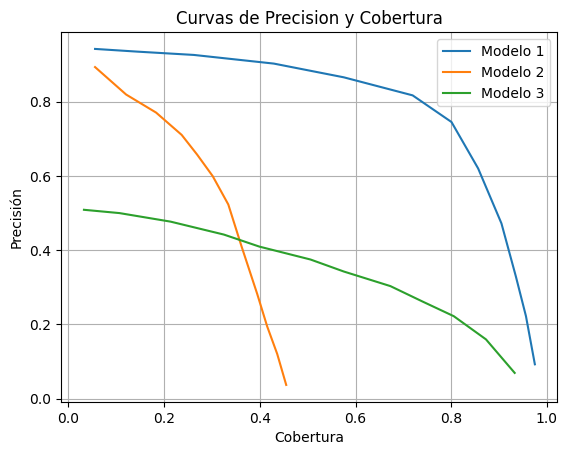

In [35]:
# Se cargan los archivos como DataFrames de Pandas
df1 = pd.read_csv('model1.csv', sep = ",")
df2 = pd.read_csv('model2.csv', sep = ",")
df3 = pd.read_csv('model3.csv', sep = ",")

# Se emplea la función np.split para separar las 4 columnas de cada archivo en vectores independientes.
_, TP1, FP1, FN1 = np.split(df1.values, 4, 1)
_, TP2, FP2, FN2 = np.split(df2.values, 4, 1)
_, TP3, FP3, FN3 = np.split(df3.values, 4, 1)

# Se calculan las precisiones y coberturas de los 3 modelos para los distintos umbrales de confianza.
precisiones = [TP1 / (TP1 + FP1), TP2 / (TP2 + FP2), TP3 / (TP3 + FP3)]
coberturas = [TP1 / (TP1 + FN1), TP2 / (TP2 + FN2), TP3 / (TP3 + FN3)]

# Se crea una visualización de las curvas de precisión y cobertura.

plt.figure()
plt.title("Curvas de Precision y Cobertura")
for i in range(3):
    plt.plot(coberturas[i], precisiones[i], label="Modelo " + str(i+1))
plt.xlabel("Cobertura")
plt.ylabel("Precisión")
plt.grid()
plt.legend()

## Evaluación de Modelos de Segmentación

La tarea de segmentación consiste en localizar todos los píxeles que corresponden a un objeto específico o estructura de interés en una imagen. Los modelos de segmentación retornan una *máscara de segmentación*, la cual corresponde a una imagen donde todos los píxeles que corresponden a una misma clase o instancia de interés tienen una misma intensidad (que se puede interpretar como una etiqueta). Para evaluar la calidad de la segmentación se calcula el Índice de Jaccard entre la máscara de segmentación retornada por el modelo y la anotación provista en la base de datos. Recuerde que el Índice de Jaccard se puede expresar de la siguiente forma:

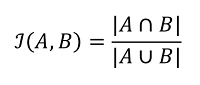

donde $A$ y $B$ corresponden a los arreglos binarios asociados a la máscara de segmentación y la anotación.

Suponga que usted desarrolló un modelo que tiene como objetivo segmentar únicamente la cebra más cercana a la cámara en la siguiente foto:

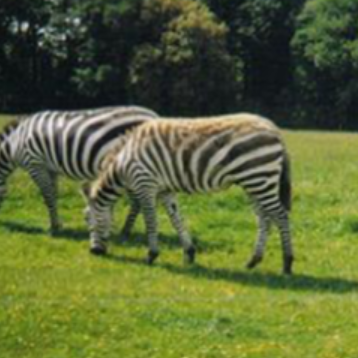


Los archivos `segmentation_mask.png` y `groundtruth.png` corresponden a la máscara de segmentación retornada por su modelo y la anotación que venía con la base de datos respectivamente. A continuación, se presenta un código que permite obtener el Índice de Jaccard asociado a estas dos imagenes:

(np.float64(-0.5), np.float64(357.5), np.float64(357.5), np.float64(-0.5))

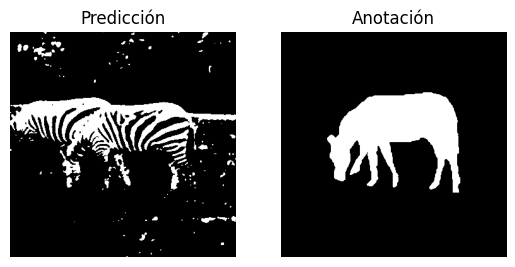

In [36]:
# La función cv2.imread nos permite importar la imagen como un arreglo de numpy de dos dimensiones
# al usar cv2.IMREAD_GRAYSCALE para cargar en escala de grises

seg_mask = cv2.imread("segmentation_mask.png")
gt = cv2.imread("groundtruth.png", cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title('Predicción')
plt.imshow(seg_mask,cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Anotación')
plt.imshow(gt,cmap='gray')
plt.axis('off')

Note que estas máscaras son binarias, es decir que solo tienen dos posibles intensidades:

In [ ]:
print("Las posibles intensidades de la máscara de segmentación son: " + str(np.unique(seg_mask)))
print("Las posibles intensidades de la anotación son: " + str(np.unique(gt)))

## Ejercicio 3

La metrica mas importante para el problema de segmentación es el indice de Jaccard, tambien conocido como intersección sobre union. Debe realizar una función que logre encontrar esta metrica dadas 2 imagenes binarias. Puede asumir que estás serán siempre arrays de numpy.
> **consejo:** recuerde que siempre será mas efectivo computacionalmente hacer operaciones entre arreglos que hacer recorridos, tenga esto en cuenta al momento de realizar su función. Tambien recuerde no agregar 2 veces la intersección al momento de calcular la union. Siga las intrucciones.

In [37]:
# Cálculo del Índice de Jaccard
def jaccard(mask1,mask2):
    interseccion= np.sum(mask1 * mask2)  # multiplique ambas mascaras y use np.sum() en la multiplicacion
    union= np.sum(mask1) + np.sum(mask2) - interseccion #use np.sum() en ambas mascaras y sume los resultados, luego reste la intersección
    J= interseccion/union #divida la interseccion entre la union
    # YOUR CODE HERE
    return J


In [38]:
try:
    jaccard(seg_mask,gt)
except:
    print('ValueError: operands could not be broadcast together with shapes (358,358,4) (358,358)')

ValueError: operands could not be broadcast together with shapes (358,358,4) (358,358)


¿Que ocurrió? Tenemos un error en nuestro codigo. El error dice que no podemos multiplicar 2 arreglos con diferentes cantidades de dimensiones. Esto se debe a que las imagenes png tienen 4 canales cuando las mascaras binarias deberian ser de solo uno. Agregue un if en su función que compruebe que las mascaras tengan solo 2 dimensiones (filas,columnas) de lo contrario, solo tome el primer canal de la mascara. Use mask.shape para obtener una tupla del tamaño del arreglo. 

In [39]:
def jaccard(mask1, mask2):
    if len(mask1.shape) != 2:
        mask1 = mask1[:, :, 0]
    if len(mask2.shape) != 2:
        mask2 = mask2[:, :, 0]

    interseccion = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2) - interseccion
    J = interseccion / union
    return J

In [40]:
jaccard(seg_mask,gt)

np.float64(0.0009779854514870995)

No todos los errores serán indicados por python. Python generará un error si se presenta algun problema en la ejecución del código, no comprueba errores de logica. El indice de jaccard no debería ser mayor a 1 en ningúna ocasión, como vimos anteriormente nuestras mascaras solo tienen 2 valores, sin embargo, una de las mascaras tiene valores de 0 o 255, el otro tiene de 0 o 1. Agregue una linea de codigo que vuelva nuestras mascaras arreglos de True y False, use el operador >, != o ==.

In [ ]:
def jaccard(mask1,mask2):
    # YOUR CODE HERE
    raise NotImplementedError()
    return J

In [ ]:
J=jaccard(seg_mask,gt)
print("El Índice de Jaccard entre ambas máscaras es: " + str(J))
assert(np.isclose(0.33181,J))

A continuación se presentará una visualización de la imagen original, la máscara de segmentación, la anotación, la intersección y la unión:

In [ ]:
# Importamos la imagen original como una imagen a color

original = cv2.imread('original.png')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib

# Creamos dos listas con las imagenes a visualizar y sus correpondientes títulos para 
# generar un subplot de forma más condensada. Note que los arreglos interseccion y union
# previamente definidos eran de caracter booleano, por lo que para visualizarlos hay que
# transformarlos en arreglos de 0s y 1s, lo cual se puede hacer mediante el método .astype()
# de los arreglos de Numpy.

interseccion=(seg_mask[:,:,0]!=0)*gt
union=seg_mask[:,:,0]+gt

imagenes = [original, seg_mask, gt, interseccion.astype(int), union.astype(bool)]
titulos = ["Imagen Original", "Máscara de Segmentación", "Anotación", "Intersección", "Unión"]

# Se genera la visualización

plt.figure(figsize=(30,20))
for i in range(len(imagenes)):
    plt.subplot(151 + i)
    plt.title(titulos[i], fontdict={"fontsize":20})
    if i != 0:
        plt.imshow(imagenes[i], cmap='gray')
    else:
        plt.imshow(imagenes[i])
    plt.axis("Off")

## Créditos ##

Danniel Moreno - Jose Miguel Abril Nova - Felipe Escallón Páez - Jose Miguel Abril Nova - Javier Santiago Vera
